<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Deep Learning in PyTorch

In [5]:
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Binary classification
For binary classification, we can use a sigmoid activation function on the output layer to get our predictions in the range (0,1) and then use PyTorch's `BCELoss()` loss function (equivalent to Negative Log Likelihood)

In [6]:
from sklearn.datasets import load_breast_cancer
data=load_breast_cancer(as_frame=True)
X,y=data.data,data.target
# Since the default in the file is 0=malignant 1=benign we want to reverse these
y=(y==0).astype(int)
X,y= np.array(X),np.array(y)

# Let's set aside a test set and use the remainder for training and cross-validation
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=0.2)

# Let's scale our data to help the algorithm converge faster
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Step 1: Set up dataloaders for our data
The first step is to set up the dataloaders to feed our data into the model.  We first create a `TensorDataset` for our training data and our test data.  Then we create `DataLoaders` for the training and test data which allow us to iteratively feed the data into our model in batches (called "mini-batches") of a size that we can specify.

In [7]:
# Set random seeds
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

# Convert training and test data to TensorDatasets
trainset = TensorDataset(torch.from_numpy(X_train_scaled).float(), 
                         torch.from_numpy(y_train).float())
testset = TensorDataset(torch.from_numpy(X_test_scaled).float(), 
                        torch.from_numpy(y_test).float())

# Create Dataloaders for our training and test data to allow us to iterate over minibatches 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

### Step 2: Define our neural network architecture
Next, we will define a model, feed-forward neural network for this chapter..
For simplicity, we will use 3-layer, 2 hidden layers and 1 hidden-to-output layer, feed-forward net. Each layer is a fully-connected layer where the module `torch.nn.Linear` is the implementation of it. Also, we will apply ReLU activation for each layer.

Basically, we are required to define a member method of `forward(self, x)` when we define a class for any customized network. It represents a forward pass of a computational graph and a backward pass (back-propagation) with automatic differentiation will be performed later based on this forward definition.

In [8]:
class FeedForwardNet(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_output):
        super().__init__()
        self.hidden1 = nn.Linear(n_input, n_hidden1)
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
        self.out = nn.Linear(n_hidden2, n_output)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = torch.sigmoid(self.out(x))
        return x

In [9]:
# Instantiate our neural network
net = FeedForwardNet(n_input=X_train_scaled.shape[1], n_hidden1=50, n_hidden2=20, n_output=1)

Alternatively, PyTorch gives us an easy way to define a model layer by layer using `nn.Sequential()` rather than creating a model class as we did above.  Here we define the same model as above much more simply:

In [10]:
# Build a feed-forward network
n_input = X_train_scaled.shape[1]
n_hidden1 = 50
n_hidden2 = 20
n_output = 1

net = nn.Sequential(nn.Linear(n_input, n_hidden1),  # hidden layer 1
                      nn.ReLU(), # hidden layer 1 activation
                      nn.Linear(n_hidden1, n_hidden2), # hidden layer 2
                      nn.ReLU(), # hidden layer 2 activation
                      nn.Linear(n_hidden2, n_output), # output layer
                      nn.Sigmoid()) # use sigmoid as output activation

### Step 3: Define a cost / loss function and optimizer
We will use Binary Cross Entropy as our loss function, which is usually named `criterion` in PyTorch.  For our optimizer we will use stochastic gradient descent (SGD).

When we create an optimizer in PyTorch, we need to pass in the parameters that we want to optimize (train), which are our weights. We can retrieve all trainable parameters of the model by calling `model.parameters()`.

In [11]:
import torch.optim as optim

# Define the cost / loss function
cost_fn = nn.BCELoss()

# Define the method of updating the weights each iteration (e.g. gradient descent)
optimizer = optim.SGD(net.parameters(), lr=0.01)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Step 4: Train the model
To train our model, we perform the following four steps in a loop, using one input mini-batch at a time:  
    1) Make a forward pass through the network to calculate the network output  
    2) Use the network output to calculate the cost/loss  
    3) Calculate the gradient of the cost/loss with respect to the weights by performing a backward pass through the network with loss.backward()  
    4) Update the weights by taking a step with the optimizer

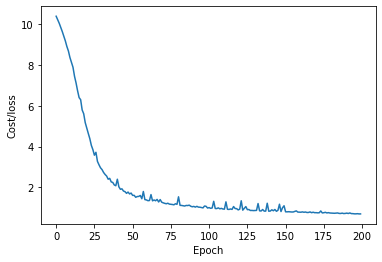

In [12]:
num_iter = 200
cost = []

net = net.to(device)
net.train() # Set the model to training mode

for epoch in range(num_iter):

    running_loss = 0.0
    
    for i, data in enumerate(trainloader):
        
        # Get the inputs X and labels y for the minibatch
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the gradients of the weights each iteration
        optimizer.zero_grad()

        # Calculate the predictions and the cost/loss
        outputs = net(inputs).view(-1) # Convert outputs to 1D array instead of 2D to match labels
        loss = cost_fn(outputs, labels)
        
        # Use autograd to calculate the gradient of the cost with respect to each weight
        loss.backward()
        
        # Use the optimizer to do the weights update
        optimizer.step()

        # Store the cost/loss
        running_loss += loss.item()
        
    cost.append(running_loss)
        
plt.plot(cost)
plt.xlabel('Epoch')
plt.ylabel('Cost/loss')
plt.show()

### Step 5: Test the model on the test set

In [14]:
# Set the model to evaluation mode
net.eval()
with torch.no_grad():
    # Set up lists to store true and predicted values
    y_true = y_test.tolist
    test_preds = []

    # Calculate the predictions on the test set and add to list
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net.forward(inputs)
        test_preds.extend(outputs.numpy().flatten().tolist())

    # Convert the predictions to discrete and calculate the accuracy
    test_preds = np.round(test_preds)
    test_acc = np.sum(test_preds==y_test)/len(y_test)
    print('Test set accuracy is {:.3f}'.format(test_acc))

Test set accuracy is 0.965


# Multiclass classification
For a multi-class problem we use a softmax as the activation function to convert the outputs to probabilities, rather than sigmoid as we did in binary classification.  We also use cross-entropy (`nn.CrossEntropyLoss()`) as the loss function rather than negative log likelihood (`BCELoss()`) as we did previously.

In [15]:
import seaborn as sns
# Load the iris dataset using a helper function in Seaborn
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [16]:
# Separate into X and y
# Convert string species values in y to numerical codes for modeling
X = iris.drop('species',axis=1)
y = iris['species'].astype('category').cat.codes

In [17]:
# Split data into training and test sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
print("Shape of X_train, y_train:",X_train.shape,y_train.shape)
print("Shape of X_test, y_test:",X_test.shape,y_test.shape)

# Let's scale our data to help the algorithm converge faster
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert y_train and y_test to arrays so all inputs are in NumPy
y_train = np.array(y_train)
y_test = np.array(y_test)

Shape of X_train, y_train: (120, 4) (120,)
Shape of X_test, y_test: (30, 4) (30,)


In [18]:
# Convert training and test data to TensorDatasets
# When we do multiclass classification, PyTorch expects that labels are type LongTensor and inputs are FloatTensor
trainset = TensorDataset(torch.from_numpy(X_train_scaled).float(), 
                         torch.from_numpy(y_train).long())
testset = TensorDataset(torch.from_numpy(X_test_scaled).float(), 
                        torch.from_numpy(y_test).long())

batchsize = 32
# Create Dataloaders for our training and test data to allow us to iterate over minibatches 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)

In [19]:
class Multiclass_Net(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_hidden3, n_output):
        super().__init__()
        self.hidden1 = nn.Linear(n_input, n_hidden1)
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
        self.hidden3 = nn.Linear(n_hidden2, n_hidden3)
        self.out = nn.Linear(n_hidden3, n_output)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = self.out(x)
        return x
    
# Instantiate our neural network
# n_input=4 since we have 4 features
# n_output=3 since we have 3 classes
net = Multiclass_Net(n_input=4, n_hidden1=100, n_hidden2=50, n_hidden3=10, n_output=3)

In [20]:
def train_model(model,criterion,optimizer,trainloader,num_iter,device):
    
    model = model.to(device)
    model.train() # Set the model to training mode
    
    cost = []
    
    for epoch in range(num_iter):

        running_loss = 0.0

        for i, data in enumerate(trainloader):

            # Get the inputs X and labels y for the minibatch
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the gradients of the weights each iteration
            optimizer.zero_grad()

            # Calculate the predictions and the cost/loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Use autograd to calculate the gradient of the cost with respect to each weight
            loss.backward()

            # Use the optimizer to do the weights update
            optimizer.step()

            # Add the loss to running loss for the epoch
            running_loss += loss.item()

        cost.append(running_loss)
    return cost

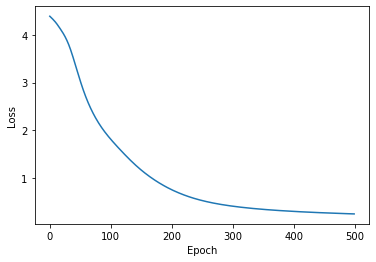

In [21]:
# Define the cost / loss function
criterion = nn.CrossEntropyLoss()
# Define the method of updating the weights each iteration
optimizer = optim.SGD(net.parameters(), lr=0.01)
# Number of iterations (epochs) to train
n_iter = 500
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train model
cost_path = train_model(net,criterion,optimizer,trainloader,n_iter,device)

# Plot the cost over training
plt.plot(cost_path)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [22]:
def test_model(model,test_loader,device):
    # Turn autograd off
    with torch.no_grad():

        # Set the model to evaluation mode
        model.eval()

        # Set up lists to store true and predicted values
        y_true = []
        test_preds = []

        # Calculate the predictions on the test set and add to list
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            # Feed inputs through model to get raw scores
            logits = net.forward(inputs)
            # Convert raw scores to probabilities (not necessary since we just care about discrete probs in this case)
            probs = F.softmax(logits,dim=1)
            # Get discrete predictions using argmax
            preds = np.argmax(probs.numpy(),axis=1)
            test_preds.extend(preds)
            y_true.extend(labels)

        # Calculate the accuracy
        test_acc = np.sum(test_preds==y_test)/len(y_test)
    
    return test_acc

In [23]:
# Test model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
acc = test_model(net,testloader,device)
print('Test set accuracy is {:.3f}'.format(acc))

Test set accuracy is 1.000


# Convolutional neural network

In [89]:
# Load training and test data
from torchvision.datasets import FashionMNIST

# Set up transforms - ToTensor only in this case
data_transform = transforms.Compose([transforms.ToTensor()]) # Converts pixel values to tensor in range [0.,1.]

# Set up datasets
train_data = FashionMNIST(root='./data', train=True,
                                   download=True, transform=data_transform)

test_data = FashionMNIST(root='./data', train=False,
                                  download=True, transform=data_transform)

print('Training data images: ', len(train_data))
print('Test data images: ', len(test_data))

# Specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Set random seeds for reproducibility
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

Training data images:  60000
Test data images:  10000


### Step 1: Set up dataloaders for our data

In [90]:
batch_size = 16

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

torch.Size([16, 1, 28, 28])


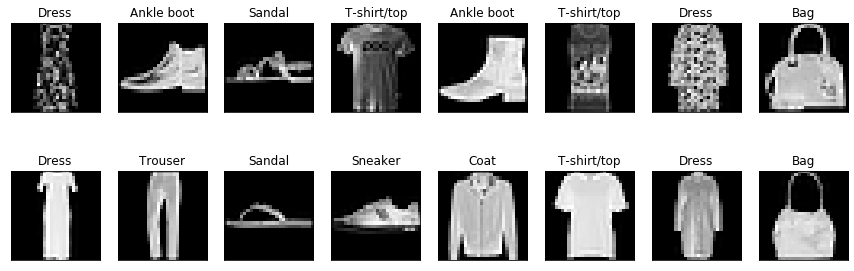

In [91]:
# Get next batch of training images
images, labels = iter(train_loader).next()
print(images.shape)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15, 5))
for idx in range(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

As we see above, the inputs in a PyTorch DataLoader are of shape [N,C,H,W) where:  
- N = batch size  
- C = number of channels (1 for grayscale, 3 for RGB color)  
- H = image height  
- W = image width

### Step 2: Define our neural network architecture

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of the network in the function `forward`, which takes in an input image tensor, `x`. During training, PyTorch will perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

A conv/pool layer may be defined like this (in `__init__`):
```
# Convolutional layer with 1 input channel (grayscale), 32 output channels/feature maps and a 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

We then define the `forward` function which governs the flow of input data through the neural network.  In this case we will apply a ReLu activation function after the convolutional layers followed by a MaxPooling layer:
```
x = self.pool(F.relu(self.conv1(x)))
```

Any layers with trainable weights, such as convolutional layers, must be contained in the `__init__` function. Any layers or functions that always behave in the same way, such as a pre-defined activation function, may appear in the `forward` function without being defined in the `__init__` function. In practice, convolutional and pooling layers are defined in `__init__` and activations are usually defined in `forward`.

For convolutional layers, the output feature maps will have the specified depth and the dimensions of each output feature map (width/height) can be computed as the input image width/height (W or H) minus the filter size (F) divided by the stride (S) + 1. The equation to calculate the output dimensions of the convolution layer is: `output_dim = (W-F)/S + 1`, for a padding size of 0. A derivation of this formula can be found [here](http://cs231n.github.io/convolutional-networks/#conv).

For a pool layer, the output can be computed as the input width/height (W) minus the filter size (F) divided by the stride (S) + 1.  The equation to calculate the output shape of the pooling layer is: `output_dim = (W-F)/S + 1`

To feed the output of a convolutional/pooling layer into a linear layer, we must first flatten the extracted features into a vector. In PyTorch we can flatten an input `x` by using `x = x.view(x.size(0), -1)`.

Finally, depending on our task we apply a final activation layer (e.g. softmax) to convert the outputs from the linear layer into class scores.  Note that some loss functions (e.g. CrossEntropy loss) include the softmax so we do not need to define it separately in the neural network architecture.

In [92]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        
        '''
        Input shape: (batch_size,1,28,28)
        
        Convolutional 1 layer: 3x3 kernel, stride=1, 10 output channels / feature maps
        Conv1 layer output dimension = (W-F)/S+1 = (28-3)/1+1 = 26
        Conv1 layer output shape for one image: (10,26,26)
        
        Pooling layer: kernel_size=2,stride=2
        Pooling1 layer output dimension = (W-F)/S+1 = (26-2)/2+1 = 13
        Pooling1 output shape for one image: (10,13,13)
        
        Convolutional 2 layer: 3x3 kernel, stride=1, 20 output channels / feature maps
        Conv2 layer output dimension = (W-F)/S+1 = (13-3)/1+1 = 11
        Conv2 layer output shape for one image: (20,11,11)
        
        Pooling layer: kernel_size=2,stride=2
        Pooling2 layer output dimension = (W-F)/S+1 = (11-2)/2+1 = 5.5 <- round down from 5.5 to 5
        Pooling2 output shape for one image: (20,5,5)
        
        
        Linear layer input shape: (batch_size, 20 channels * 5 * 5)
        Linear layer output shape: (batch_size, 10 output classes)
        
        '''
        
        # Convolutional 1 layer: 3x3 kernel, stride=1, 10 output channels / feature maps
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1)
        # Conv1 layer output size = (W-F)/S+1 = (28-3)/1+1 = 26
        # Conv1 layer output shape for one image: (10,26,26)
        
        # maxpool layer
        # pool with kernel_size=2, stride=2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Pool output shape for one image: (10,13,13)
        
        # Convolutional 2 layer: 3x3 kernel, stride=1, 20 output channels / feature maps
        self.conv2 = nn.Conv2d(in_channels=10,out_channels=20,kernel_size=3)
        # Conv2 layer output size = (W-F)/S+1 = (13-3)/1+1 = 11
        # Conv2 layer output shape for one image: (20,11,11)
        
        # maxpool layer
        # pool with kernel_size=2, stride=2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Pool output shape for one image: (20,5,5)
        
        # Input size: 20 * 5 * 5 = 500 from pool2 pooling layer
        # 10 output channels (for the 10 classes)
        self.fc1 = nn.Linear(20*5*5, 10)
        
    def forward(self, x):
        # Two convolutional layers followed by relu and then pooling
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        # Flatten into a vector to feed into linear layer
        x = x.view(x.size(0), -1)
        
        # Linear layer
        x = self.fc1(x)
        
        return x

net = ConvNet()

### Step 3: Define a cost / loss function and optimizer

In [94]:
# Cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

### Step 4: Train the model
To train our model, we perform the following four steps in a loop, using one input mini-batch at a time:  
    1) Make a forward pass through the network to calculate the network output  
    2) Use the network output to calculate the cost/loss  
    3) Calculate the gradient of the cost/loss with respect to the weights by performing a backward pass through the network with loss.backward()  
    4) Update the weights by taking a step with the optimizer

If GPU is available, we can move the model (all its parameter Tensors) onto GPU. If we decided to use GPU, we also need to put all the data Tensors used in training onto GPU.

In [95]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch: 1, Batch: 1000, Avg. Loss: 1.2316
Epoch: 1, Batch: 2000, Avg. Loss: 0.6716
Epoch: 1, Batch: 3000, Avg. Loss: 0.5832
Epoch: 2, Batch: 1000, Avg. Loss: 0.5177
Epoch: 2, Batch: 2000, Avg. Loss: 0.4960
Epoch: 2, Batch: 3000, Avg. Loss: 0.4840
Epoch: 3, Batch: 1000, Avg. Loss: 0.4605
Epoch: 3, Batch: 2000, Avg. Loss: 0.4505
Epoch: 3, Batch: 3000, Avg. Loss: 0.4345
Epoch: 4, Batch: 1000, Avg. Loss: 0.4166
Epoch: 4, Batch: 2000, Avg. Loss: 0.4070
Epoch: 4, Batch: 3000, Avg. Loss: 0.4208
Epoch: 5, Batch: 1000, Avg. Loss: 0.3953
Epoch: 5, Batch: 2000, Avg. Loss: 0.3973
Epoch: 5, Batch: 3000, Avg. Loss: 0.3980


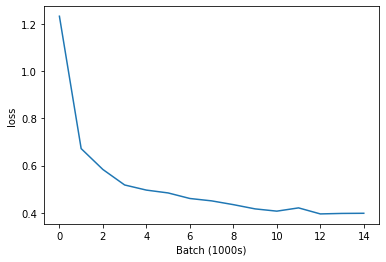

In [96]:
def train_model(model,criterion,optimizer,train_loader,n_epochs,device):
    
    loss_over_time = [] # to track the loss as the network trains
    
    model = model.to(device) # Send model to GPU if available
    model.train() # Set the model to training mode
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for i, data in enumerate(train_loader):
            
            # Get the input images and labels, and send to GPU if available
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the weight gradients
            optimizer.zero_grad()

            # Forward pass to get outputs
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backpropagation to get the gradients with respect to each weight
            loss.backward()

            # Update the weights
            optimizer.step()

            # Convert loss into a scalar and add it to running_loss
            running_loss += loss.item()
            
            if i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {:.4f}'.format(epoch + 1, i+1, avg_loss))
                running_loss = 0.0

    return loss_over_time

# Train the model
n_epochs = 5
cost_path = train_model(net,criterion,optimizer,train_loader,n_epochs,device)

# visualize the loss as the network trained
plt.plot(cost_path)
plt.xlabel('Batch (1000s)')
plt.ylabel('loss')
plt.show()

### Step 5: Test the model on the test set

`MODEL.train()` and `MODEL.eval()` are functions acting as a switch which turns on/off any randomness of layers in the model such as dropout which are used to improve training but which we do not want to use while testing / in production.

In [59]:
def test_model(model,test_loader,device):
    # Turn autograd off
    with torch.no_grad():

        # Set the model to evaluation mode
        model = model.to(device)
        model.eval()

        # Set up lists to store true and predicted values
        y_true = []
        test_preds = []

        # Calculate the predictions on the test set and add to list
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            # Feed inputs through model to get raw scores
            logits = net.forward(inputs)
            # Convert raw scores to probabilities (not necessary since we just care about discrete probs in this case)
            probs = F.softmax(logits,dim=1)
            # Get discrete predictions using argmax
            preds = np.argmax(probs.numpy(),axis=1)
            # Add predictions and actuals to lists
            test_preds.extend(preds)
            y_true.extend(labels)

        # Calculate the accuracy
        test_preds = np.array(test_preds)
        y_true = np.array(y_true)
        test_acc = np.sum(test_preds == y_true)/y_true.shape[0]
        
        # Recall for each class
        recall_vals = []
        for i in range(10):
            class_idx = np.argwhere(y_true==i)
            total = len(class_idx)
            correct = np.sum(test_preds[class_idx]==i)
            recall = correct / total
            recall_vals.append(recall)
    
    return test_acc,recall_vals

acc,recall_vals = test_model(net,test_loader,device)
print('Test set accuracy is {:.3f}'.format(acc))
for i in range(10):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))

Test set accuracy is 0.853
For class T-shirt/top, recall is 0.89
For class Trouser, recall is 0.968
For class Pullover, recall is 0.804
For class Dress, recall is 0.834
For class Coat, recall is 0.829
For class Sandal, recall is 0.941
For class Shirt, recall is 0.404
For class Sneaker, recall is 0.946
For class Bag, recall is 0.96
For class Ankle boot, recall is 0.95


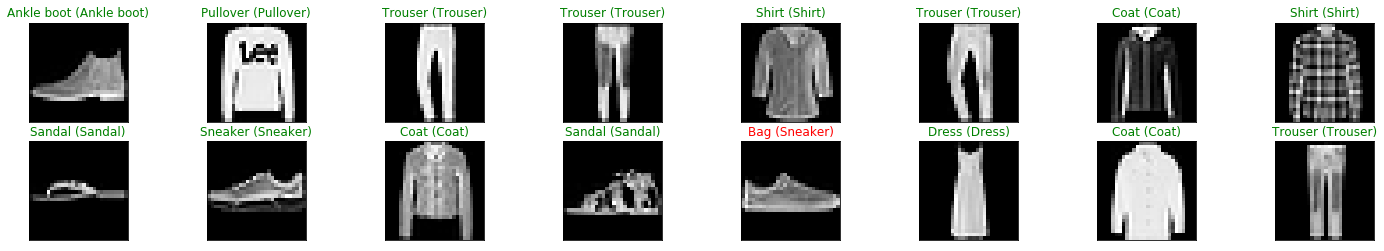

In [60]:
# Get a batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

### Saving models
To save PyTorch models for later use, we have two options:  
1) We can save the `state_dict` which contains all the learned parameters of the model (the weights and biases) but not the architecture itself.  To use it, we instantiate a new model of the desired architecture and then load the saved `state_dict` to assign values to all the parameters in the model  
2) We can alternatively save the entire model including the architecture, and then load it up and use it for prediction

In [61]:
# OPTION 1: Save the state dictionary of the model

model_dir = 'saved_models/'
filename = 'model_state_dict.pt'

# Save the model's learned parameters (state_dict)
torch.save(net.state_dict(), model_dir+filename)

In [64]:
# Initialize new model as ConvNet() class and load state dict previously saved
model = ConvNet()
model.load_state_dict(torch.load(model_dir+filename))

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    
# Test loaded model
acc,recall_vals = test_model(model,test_loader,device)
print()
print('Test set accuracy is {:.3f}'.format(acc))
for i in range(10):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))

Model's state_dict:
conv1.weight 	 torch.Size([10, 1, 3, 3])
conv1.bias 	 torch.Size([10])
conv2.weight 	 torch.Size([20, 10, 3, 3])
conv2.bias 	 torch.Size([20])
fc1.weight 	 torch.Size([10, 500])
fc1.bias 	 torch.Size([10])

Test set accuracy is 0.853
For class T-shirt/top, recall is 0.89
For class Trouser, recall is 0.968
For class Pullover, recall is 0.804
For class Dress, recall is 0.834
For class Coat, recall is 0.829
For class Sandal, recall is 0.941
For class Shirt, recall is 0.404
For class Sneaker, recall is 0.946
For class Bag, recall is 0.96
For class Ankle boot, recall is 0.95


In [ ]:
# OPTION 2: Save the entire model

model_dir = 'saved_models/'
filename = 'fullmodel.pt'

# Save the entire model
torch.save(net, model_dir+filename)

In [ ]:
# Load model
model2 = torch.load(model_dir+filename)

# Test loaded model
acc,recall_vals = test_model(model2,test_loader,device)
print('Test set accuracy is {:.3f}'.format(acc))
for i in range(10):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))

# Using Pre-trained Models
Rather than creating our own model from scratch, we can use models which have been pre-trained on other generic tasks to take advantage of the training that has already occurred.  When we do this, we usually keep the model parameters fixed except for the last layer.  We use a new last layer (a fully connected Linear layer) which we then train on our specific task.

All models which have been pre-trained on ImageNet expect input images normalized in the same way, i.e. mini-batches of 3-channel
RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded with pixel values a range of [0, 1] (accomplished by using `transforms.ToTensor()`) and then normalized using the mean and standard deviation of image pixel values.  Since it can be difficult to calculate these statistics, we often just normalize by the mean and standard deviation of the ImageNet images, which are mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize: `normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])`

In this example we will load a ResNet18 model and use it on the FashionMNIST dataset. The FashionMNIST dataset has a couple of differences relative to the ImageNet dataset on which pretrained models are trained:  
- It is grayscale so has only 1 channel instead of 3. 
- It is 28*28 rather than 224*224. 
- The pixel values mean and standard deviation are quite different from the images in ImageNet  
- We have only 10 classes as output

Because of those differences, we need to make two adjustments to use our pretrained model:  
1) We need to transform our input image data to be 224*224 and normalize using the images mean and standard deviation  
2) We need to change our net architecture to accomodate 1 input channel, and 10 output classes

NOTE: THIS MUST BE RUN ON GPU

In [ ]:
# We need to add a transformation to our input image data
# Resnet18 expects input images of shape 224*224
# We also should normalize our pixel values by subracting mean and dividing by standard deviation of training set values

train_data = FashionMNIST(root='./data', train=True, download=True)

data_transform = transforms.Compose([ transforms.Resize((224, 224)),
                                         transforms.ToTensor(), 
                                         transforms.Normalize((train_data.data.float().mean()/255), (train_data.data.float().std()/255))])

train_data_resnet = FashionMNIST(root='./data', train=True,
                                   download=True, transform=data_transform)

test_data_resnet = FashionMNIST(root='./data', train=False,
                                  download=True, transform=data_transform)

batch_size = 16
train_loader_resnet = DataLoader(train_data_resnet,batch_size=batch_size, shuffle=True)
test_loader_resnet = DataLoader(test_data_resnet,batch_size=batch_size, shuffle=False)

In [ ]:
# Load a resnet18 pre-trained model
model_resnet = torchvision.models.resnet18(pretrained=True)
# Shut off autograd for all layers to freeze model so the layer weights are not trained
for param in model_resnet.parameters():
    param.requires_grad = False
    
# Replace the resnet input layer to take in grayscale images (1 input channel), since it was trained on color (3 input channels)
in_channels = 1
model_resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Replace the resnet final layer with a new fully connected Linear layer we will train on our task
# Number of out units is number of classes (10)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 10)

# Train the model
n_epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cost_path = train_model(model_resnet,criterion,optimizer,train_loader_resnet,n_epochs,device)

# Visualize the loss as the network trained
plt.plot(cost_path)
plt.xlabel('Batch (1000s)')
plt.ylabel('loss')
plt.show()

In [ ]:
# Test the pre-trained model
acc,recall_vals = test_model(model_resnet,test_loader_resnet,device)
print('Test set accuracy is {:.3f}'.format(acc))
for i in range(10):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))